<a href="https://colab.research.google.com/github/varshitha102/Smart-Waste-Classifier/blob/main/Smart_Garbage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sumn2u/garbage-classification-v2
!unzip garbage-classification-v2.zip -d garbage_data

Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
License(s): MIT
garbage-classification-v2.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  garbage-classification-v2.zip
replace garbage_data/garbage-dataset/battery/battery_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# ** 1. Setup and Imports**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Classes (Adjust if needed)
class_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass',
               'metal', 'paper', 'plastic', 'shoes', 'trash']
num_classes = len(class_names)


### 2. Dataset and DataLoader

In [ ]:
# Directory of the dataset
data_dir = "/content/garbage_data/garbage-dataset"

# Transforms (ImageNet style)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = DataLoader(full_dataset, batch_size=32, shuffle=True)


### 3. Model Loader Function (ResNet, MobileNet, EfficientNet)

In [ ]:
def get_model(name):
    if name == "resnet":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == "mobilenet":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)

    elif name == "efficientnet":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    else:
        raise ValueError("❌ Unsupported model name")

    return model.to(device)


### 4. Training Function

In [ ]:
def train_model(model_name, num_epochs=10):
    model = get_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(dataloader, desc=f"{model_name.upper()} Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"✅ {model_name.upper()} Epoch {epoch+1}: Loss={total_loss/len(dataloader):.4f}, Acc={acc:.2f}%")

    torch.save(model.state_dict(), f"{model_name}_garbage.pth")
    print(f"📦 Saved model as {model_name}_garbage.pth")
    return model


### 5. Prediction Function

In [ ]:
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms

# Define which classes are biodegradable
BIODEGRADABLE_CLASSES = {'biological', 'cardboard', 'clothes', 'paper', 'shoes'}

def predict_image(img_path, model, class_names):
    model.eval()

    # Image transformation (inside the function)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Load and preprocess the image
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probs = F.softmax(outputs, dim=1)
        conf, predicted = torch.max(probs, 1)

    class_name = class_names[predicted.item()]
    waste_type = "Biodegradable" if class_name in BIODEGRADABLE_CLASSES else "Non-Biodegradable"

    print(f"🧠 Predicted: {class_name} ({conf.item()*100:.2f}%) ➡️ {waste_type}")
    return class_name, waste_type


6. Testing

In [ ]:
# Train any model
model1 = train_model("efficientnet")  # Options: "resnet", "mobilenet", "efficientnet"

# Predict on a new image
# predict_image("path_to_image.jpg", model, transform, class_names)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
EFFICIENTNET Epoch 1/10: 100%|██████████| 618/618 [03:12<00:00,  3.22it/s]


✅ EFFICIENTNET Epoch 1: Loss=0.3494, Acc=89.45%


EFFICIENTNET Epoch 2/10: 100%|██████████| 618/618 [03:12<00:00,  3.21it/s]


✅ EFFICIENTNET Epoch 2: Loss=0.1300, Acc=95.77%


EFFICIENTNET Epoch 3/10: 100%|██████████| 618/618 [03:14<00:00,  3.17it/s]


✅ EFFICIENTNET Epoch 3: Loss=0.0838, Acc=97.18%


EFFICIENTNET Epoch 4/10: 100%|██████████| 618/618 [03:10<00:00,  3.24it/s]


✅ EFFICIENTNET Epoch 4: Loss=0.0659, Acc=97.90%


EFFICIENTNET Epoch 5/10: 100%|██████████| 618/618 [03:10<00:00,  3.25it/s]


✅ EFFICIENTNET Epoch 5: Loss=0.0530, Acc=98.31%


EFFICIENTNET Epoch 6/10: 100%|██████████| 618/618 [03:10<00:00,  3.25it/s]


✅ EFFICIENTNET Epoch 6: Loss=0.0483, Acc=98.38%


EFFICIENTNET Epoch 7/10: 100%|██████████| 618/618 [03:10<00:00,  3.25it/s]


✅ EFFICIENTNET Epoch 7: Loss=0.0415, Acc=98.67%


EFFICIENTNET Epoch 8/10: 100%|██████████| 618/618 [03:10<00:00,  3.25it/s]


✅ EFFICIENTNET Epoch 8: Loss=0.0395, Acc=98.69%


EFFICIENTNET Epoch 9/10: 100%|██████████| 618/618 [03:09<00:00,  3.26it/s]


✅ EFFICIENTNET Epoch 9: Loss=0.0390, Acc=98.59%


EFFICIENTNET Epoch 10/10: 100%|██████████| 618/618 [03:09<00:00,  3.26it/s]


✅ EFFICIENTNET Epoch 10: Loss=0.0347, Acc=98.90%
📦 Saved model as efficientnet_garbage.pth


In [ ]:
predict_image("/content/image1.jpg", model1,class_names)

🧠 Predicted: clothes (98.31%) ➡️ Biodegradable


('clothes', 'Biodegradable')

In [ ]:
# Train any model
model2 = train_model("resnet")  # Options: "resnet", "mobilenet", "efficientnet"



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.8MB/s]
RESNET Epoch 1/10: 100%|██████████| 618/618 [02:37<00:00,  3.93it/s]


✅ RESNET Epoch 1: Loss=0.3981, Acc=87.25%


RESNET Epoch 2/10: 100%|██████████| 618/618 [02:34<00:00,  4.00it/s]


✅ RESNET Epoch 2: Loss=0.2068, Acc=93.31%


RESNET Epoch 3/10: 100%|██████████| 618/618 [02:34<00:00,  3.99it/s]


✅ RESNET Epoch 3: Loss=0.1321, Acc=95.77%


RESNET Epoch 4/10: 100%|██████████| 618/618 [02:35<00:00,  3.98it/s]


✅ RESNET Epoch 4: Loss=0.1123, Acc=96.20%


RESNET Epoch 5/10: 100%|██████████| 618/618 [02:35<00:00,  3.99it/s]


✅ RESNET Epoch 5: Loss=0.0843, Acc=97.23%


RESNET Epoch 6/10: 100%|██████████| 618/618 [02:35<00:00,  3.96it/s]


✅ RESNET Epoch 6: Loss=0.0835, Acc=97.27%


RESNET Epoch 7/10: 100%|██████████| 618/618 [02:35<00:00,  3.98it/s]


✅ RESNET Epoch 7: Loss=0.0659, Acc=97.84%


RESNET Epoch 8/10: 100%|██████████| 618/618 [02:35<00:00,  3.97it/s]


✅ RESNET Epoch 8: Loss=0.0606, Acc=97.93%


RESNET Epoch 9/10: 100%|██████████| 618/618 [02:36<00:00,  3.95it/s]


✅ RESNET Epoch 9: Loss=0.0457, Acc=98.56%


RESNET Epoch 10/10: 100%|██████████| 618/618 [02:36<00:00,  3.94it/s]


✅ RESNET Epoch 10: Loss=0.0512, Acc=98.29%
📦 Saved model as resnet_garbage.pth


TypeError: predict_image() takes 3 positional arguments but 4 were given

In [ ]:
# 4 # Predict on a new image
# 5 predict_image("/content/image1.jpg", model2, transform, class_names)

# TypeError: predict_image() takes 3 positional arguments but 4 were given
# cleared that error here

# Predict on a new image
predict_image("/content/plastic_bottl.jpg", model2, class_names)

🧠 Predicted: clothes (82.72%) ➡️ Biodegradable


('clothes', 'Biodegradable')

In [ ]:
# Train any model
model3 = train_model("mobilenet")  # Options: "resnet", "mobilenet", "efficientnet"

# Predict on a new image
predict_image("/content/plastic_bottl.jpg", model3, class_names)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 90.6MB/s]
MOBILENET Epoch 1/10: 100%|██████████| 618/618 [02:49<00:00,  3.64it/s]


✅ MOBILENET Epoch 1: Loss=0.3745, Acc=87.80%


MOBILENET Epoch 2/10: 100%|██████████| 618/618 [02:48<00:00,  3.66it/s]


✅ MOBILENET Epoch 2: Loss=0.1939, Acc=93.68%


MOBILENET Epoch 3/10: 100%|██████████| 618/618 [02:54<00:00,  3.54it/s]


✅ MOBILENET Epoch 3: Loss=0.1391, Acc=95.61%


MOBILENET Epoch 4/10: 100%|██████████| 618/618 [02:48<00:00,  3.67it/s]


✅ MOBILENET Epoch 4: Loss=0.1191, Acc=96.11%


MOBILENET Epoch 5/10: 100%|██████████| 618/618 [02:47<00:00,  3.69it/s]


✅ MOBILENET Epoch 5: Loss=0.0903, Acc=97.08%


MOBILENET Epoch 6/10: 100%|██████████| 618/618 [02:47<00:00,  3.68it/s]


✅ MOBILENET Epoch 6: Loss=0.0833, Acc=97.18%


MOBILENET Epoch 7/10: 100%|██████████| 618/618 [02:48<00:00,  3.67it/s]


✅ MOBILENET Epoch 7: Loss=0.0749, Acc=97.55%


MOBILENET Epoch 8/10: 100%|██████████| 618/618 [02:47<00:00,  3.69it/s]


✅ MOBILENET Epoch 8: Loss=0.0651, Acc=97.82%


MOBILENET Epoch 9/10: 100%|██████████| 618/618 [02:46<00:00,  3.70it/s]


✅ MOBILENET Epoch 9: Loss=0.0677, Acc=97.81%


MOBILENET Epoch 10/10: 100%|██████████| 618/618 [02:47<00:00,  3.68it/s]

✅ MOBILENET Epoch 10: Loss=0.0591, Acc=97.99%
📦 Saved model as mobilenet_garbage.pth
🧠 Predicted: glass (96.68%) ➡️ Non-Biodegradable


('glass', 'Non-Biodegradable')

### **7. Model Analysis Function (Accuracy, Loss, Per-Class Accuracy)**

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def analyze_model(model, dataloader, class_names, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=3)
    print("📊 Classification Report:\n")
    print(report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("🧾 Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return report


### 8. Per-Model Comparison Helper

In [ ]:
import torch


def compare_models(model_names, dataloader, class_names, num_classes, device):
    all_reports = {}

    for name in model_names:
        print(f"\n🔍 Analyzing {name.upper()}")

        model = get_model(name, num_classes, device)
        model_path = f"{name}_garbage.pth"

        try:
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.to(device)
            report = analyze_model(model, dataloader, class_names, device)
            all_reports[name] = report
        except FileNotFoundError:
            print(f"❌ Model weights not found for {name}: {model_path}")

    return all_reports


### 9.Analysis

In [30]:
import os
import shutil
import random

# Source and target directories
source_root = '/content/garbage_data/garbage-dataset'
target_root = '/content/test_data'

# Ensure target root exists
os.makedirs(target_root, exist_ok=True)

# Loop through each class folder
for class_name in os.listdir(source_root):
    source_class_dir = os.path.join(source_root, class_name)
    target_class_dir = os.path.join(target_root, class_name)

    if not os.path.isdir(source_class_dir):
        continue

    # Create target class directory
    os.makedirs(target_class_dir, exist_ok=True)

    # Randomly select 100 images
    all_images = os.listdir(source_class_dir)
    selected_images = random.sample(all_images, min(100, len(all_images)))

    # Copy selected images
    for img_name in selected_images:
        src_path = os.path.join(source_class_dir, img_name)
        dst_path = os.path.join(target_class_dir, img_name)
        shutil.copy(src_path, dst_path)

print("✅ 100 images per class copied to 'test_data' successfully!")


✅ 100 images per class copied to 'test_data' successfully!


In [31]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define test data directory
test_dir = "test_data"

# Define same transforms used during training
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225])
])


In [32]:
# Create test dataset and dataloader
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Extract class names
class_names = test_dataset.classes



🔍 Analyzing RESNET


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📊 Classification Report:

              precision    recall  f1-score   support

     battery      0.989     0.989     0.989       268
  biological      1.000     1.000     1.000       277
   cardboard      0.965     0.993     0.979       278
     clothes      1.000     1.000     1.000       294
       glass      1.000     0.970     0.985       296
       metal      0.989     0.993     0.991       269
       paper      0.996     0.971     0.984       280
     plastic      0.976     0.996     0.986       280
       shoes      0.989     0.989     0.989       278
       trash      0.996     1.000     0.998       267

    accuracy                          0.990      2787
   macro avg      0.990     0.990     0.990      2787
weighted avg      0.990     0.990     0.990      2787



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


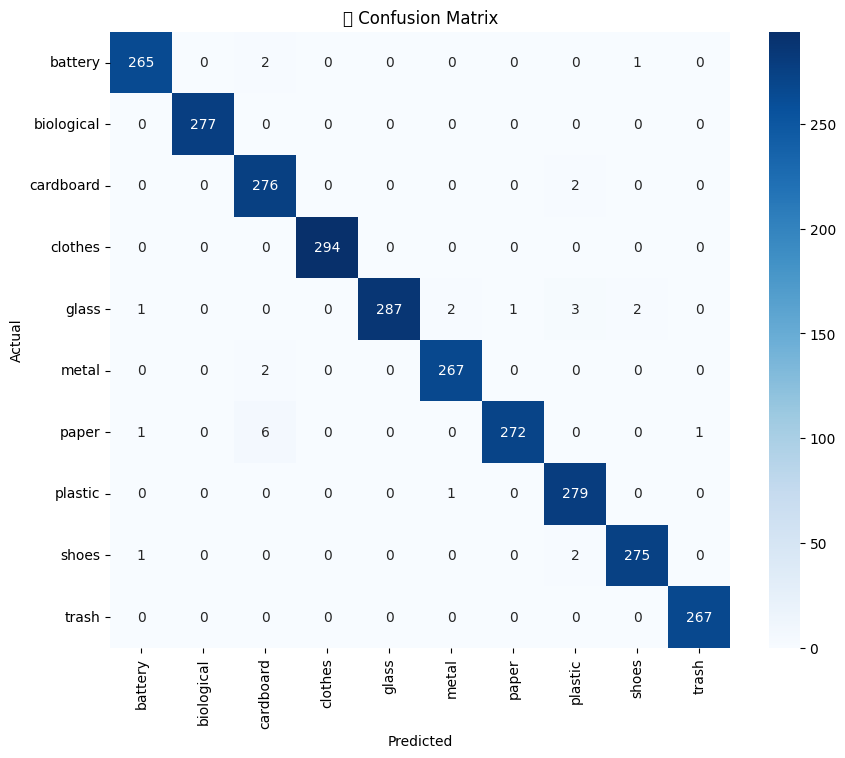


🔍 Analyzing MOBILENET


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📊 Classification Report:

              precision    recall  f1-score   support

     battery      1.000     1.000     1.000       268
  biological      0.996     0.975     0.985       277
   cardboard      0.996     0.993     0.995       278
     clothes      1.000     1.000     1.000       294
       glass      0.990     0.993     0.992       296
       metal      0.996     0.993     0.994       269
       paper      0.996     0.986     0.991       280
     plastic      0.972     0.989     0.981       280
       shoes      1.000     1.000     1.000       278
       trash      0.978     0.996     0.987       267

    accuracy                          0.992      2787
   macro avg      0.993     0.992     0.992      2787
weighted avg      0.993     0.992     0.992      2787



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


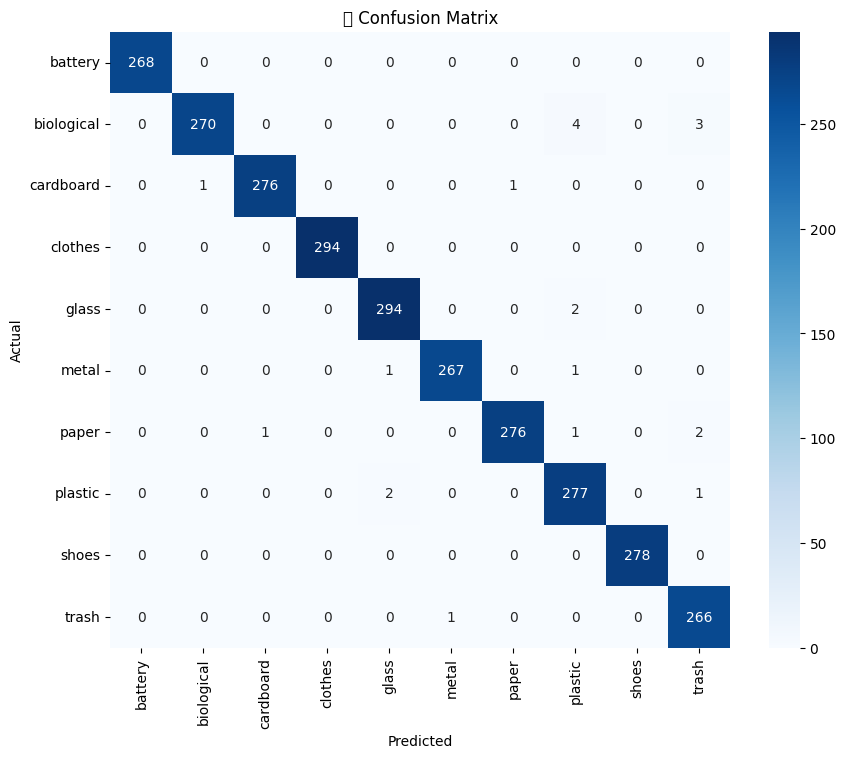

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🔍 Analyzing EFFICIENTNET
📊 Classification Report:

              precision    recall  f1-score   support

     battery      0.996     1.000     0.998       268
  biological      1.000     1.000     1.000       277
   cardboard      0.996     1.000     0.998       278
     clothes      0.993     1.000     0.997       294
       glass      1.000     0.993     0.997       296
       metal      1.000     0.993     0.996       269
       paper      1.000     1.000     1.000       280
     plastic      1.000     1.000     1.000       280
       shoes      0.996     0.993     0.995       278
       trash      0.996     1.000     0.998       267

    accuracy                          0.998      2787
   macro avg      0.998     0.998     0.998      2787
weighted avg      0.998     0.998     0.998      2787



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


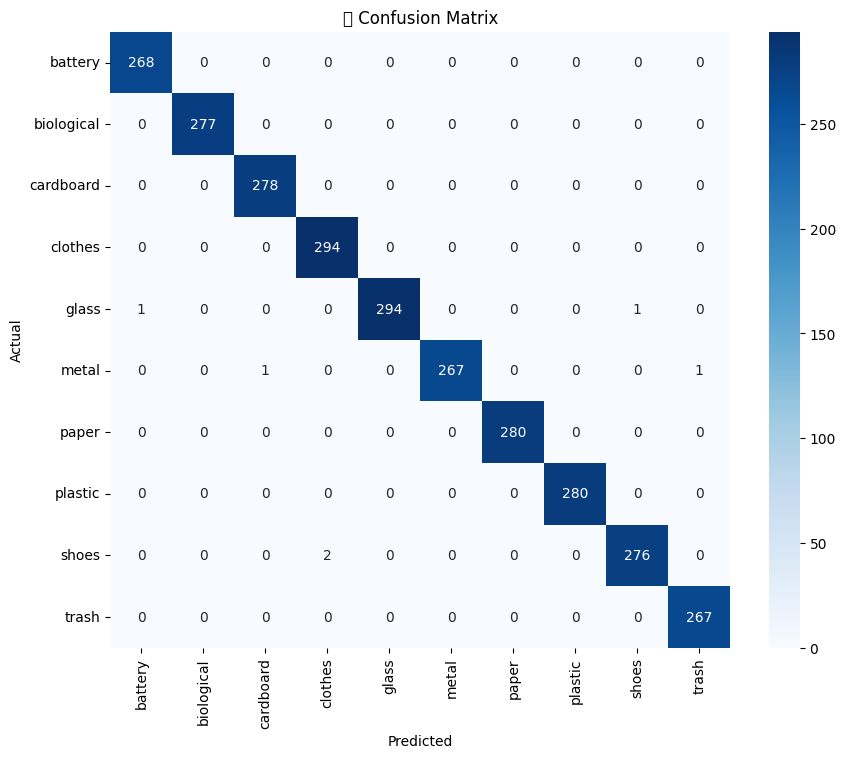

In [36]:
model_names = ['resnet', 'mobilenet', 'efficientnet']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_names)

# Run comparison
reports = {}
for name in model_names:
    print(f"\n🔍 Analyzing {name.upper()}")

    model = get_model(name)  # Only pass name
    model_path = f"{name}_garbage.pth"

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        report = analyze_model(model, test_loader, class_names, device)
        reports[name] = report
    except FileNotFoundError:
        print(f"❌ Model weights not found for {name}: {model_path}")

# Optional: Save reports
for model_name, report in reports.items():
    with open(f"{model_name}_report.txt", "w") as f:
        f.write(report)
